In [1]:
import numpy

# load the emission and transition probabilities
transition = numpy.loadtxt("typing_transition_matrix.csv", delimiter = ",", skiprows = 1)
emission = numpy.loadtxt("typing_emission_matrix.csv", delimiter = ",", skiprows = 1)

# a) Implement the forward-backward algorithm to obtain samples from the posterior distribution of the latent state sequence given the observed sequence.

In [2]:
def filterForward(transition, emission, data):
    """ Calculates and returns the probability of each hidden state being in each location given the observed
    sequence (translated into indices of the emission table) and probabilities of transition and emission. """
    
    # empty forward message
    m = numpy.empty((len(data), transition.shape[0]))
    # and a variable to hold the sum of the log normalizing constants
    normc = 0
    # fill the first column
    m[0, :] = emission[:, data[0]]/transition.shape[0]
    # and normalize
    normc = numpy.log(numpy.sum(m[0, :]))
    m[0, :] = m[0, :]/numpy.sum(m[0, :])
    
    # loop through the message and fill each column
    for t in range(1, len(data)):
        # calculate the message
        m[t, :] = numpy.dot(numpy.transpose(transition), m[t-1, :])*emission[:, data[t]]
        # and normalize it
        normc += numpy.log(numpy.sum(m[t, :]))
        m[t, :] = m[t, :]/numpy.sum(m[t, :])
    
    # return the forward message and the cumulative log normalizing constant
    return m, normc


def backSample(transition, emission, data):
    """ Sample hidden states backwards. """
    
    # first calculate the probability of each hidden state being in each location by filtering forward
    m, normc = filterForward(transition, emission, data)
    
    # create a list to hold the sampled states
    samples = numpy.empty(len(data), dtype = int)
    # initialize the last letter based on m
    samples[len(data)-1] = numpy.random.choice(27, p = m[len(data)-1])
    
    # loop thorugh the data backwards and sample hidden states
    for d in range(len(data)-2, -1, -1):
        # calculate the distribution for the next hidden state
        dist = m[d]*transition[:, samples[d+1]]
        # and normalize it
        dist = dist/numpy.sum(dist)
        # now sample an index from the distribution we just generated
        samples[d] = numpy.random.choice(27, p = dist)
    
    # return the samples
    return samples

# b) Use the algorithm to sample a few thousand possible intended sequences given the observed sequence "kezrninh".

# c) Check to see if the results are actual words and only print out the ones that are.

In [3]:
import text_utils

# transform the string into a sequence of indicies for convenience
d = text_utils.encode_string_to_int_list("kezrninh")
# save the dictionary
engdict = text_utils.dict_from_file("brit-a-z.txt")

# run the algorithm 1000 times, printing out each possible intended sequece that is a real English word
for i in range(5000):
    r = backSample(transition, emission, d)
    result = text_utils.decode_int_list_to_string(r)
    # check to see if the word is in the dictionary
    if text_utils.check_validity(result, engdict):
        print(result)

lead inn
learning
meat inn
learning
mead inn
learning
lest inn
learning
jest inn
learning
learning
lead inn
learning
learning


# d) Implement a Gibbs sampler that alternates between sampling hidden sequences conditioned on a best guess for transition and emission, and sampling transition and emission probabilities based on the current guess at the hidden sequence.

In [4]:
def HMMGibbs(data, iters, alpha_transition, alpha_emission, K_emission):
    """ Uses Gibbs sampling to estimate the posterior on the transition and emission probabilities. """
    
    # array to store all of the generated sequences
    seqs = numpy.empty((iters, data.shape[0]), dtype = int)
    # with the input data as the first sequence
    seqs[0, :] = data
    # another to store the generated transition probabilities
    transitions = numpy.empty((iters, 27, 27))
    # and the generated emission probabilities
    emissions = numpy.empty((iters, 27, 27))
    
    # alternate updating parameters to sample from the posterior and sampling sequences
    for i in range(iters):
        # update each row individually
        for k in range(27):
            # grab the indicies of the current best guess with value k
            ks = numpy.where(seqs[i, :] == k)[0]
            
            # calculate the number of times each transition occurs
            nk_transition = numpy.zeros(27)
            for kdex in ks:
                if kdex < data.shape[0]-1:
                    nk_transition[seqs[i, kdex+1]] += 1
            # update the posterior on the transitions
            transition_posterior = nk_transition + alpha_transition/27
            # sample transitions from the dirichlet
            transitions[i, k, :] = numpy.random.dirichlet(transition_posterior)
            
            # calculate the number of times each emission occurs
            nk_emission = numpy.zeros(27)
            for kdex in ks:
                nk_emission[data[kdex]] += 1
            # update the posterior on the emissions
            emission_posterior = nk_emission + alpha_emission/27
            # add K to the value corresponding to the intended letter being generated
            emission_posterior[k] += K_emission
            # sample emissions from the dirichlet
            emissions[i, k, :] = numpy.random.dirichlet(emission_posterior)
        
        # sample a new sequence using the forward-backward algorithm unless this is the last iteration
        if i+1 < iters:
            seqs[i+1, :] = backSample(transitions[i, :, :], emissions[i, :, :], data)
    
    # return the results
    return seqs, transitions, emissions

# e) Generate three random sequences using the ground truth emission and transition probabilities and use them to train, determine the appropriate hyper-parameter values, and test the Gibbs sampler. Compare the best results to the actual probabilities.

In [5]:
def generateSeq(transition, emission, length):
    """ Generates a random sequence of the provided length using the provided emission and transition probabilities. """
    
    # create a list to hold the hidden states
    hiddens = numpy.empty(length, dtype = int)
    # and another to hold the resulting visible states
    visibles = numpy.empty(length, dtype = int)
    
    # generate the designated number of hidden and visible states
    for i in range(length):
        if i == 0:
            # choose a random starting hidden state
            hiddens[i] = numpy.random.choice(27)
        else:
            # or use the previous hidden state to determine the next
            hiddens[i] = numpy.random.choice(27, p = transition[hiddens[i-1], :]/numpy.sum(transition[hiddens[i-1], :]))
        # and generate the corresponding visible state
        visibles[i] = numpy.random.choice(27, p = emission[hiddens[i], :]/numpy.sum(emission[hiddens[i], :]))
        
    # return the completed sequences
    return hiddens, visibles

In [6]:
def validation(trainset, validset, transition_alphas, emission_alphas, emission_Ks):
    """ Finds the marginal likelihood of the validation set for each combination of parameter values. """
    
    # create an array to hold the marginal likelihood of each combination
    marginalL = numpy.empty((len(transition_alphas), len(emission_alphas), len(emission_Ks)))
    
    for ta in range(len(transition_alphas)):
        for ea in range(len(emission_alphas)):
            for eK in range(len(emission_Ks)):
                # run Gibbs sampling for each combination of parameters
                seq, transition, emission = HMMGibbs(trainset, 5000, transition_alphas[ta], 
                                                     emission_alphas[ea], emission_alphas[ea])
                # average all the post burn in transition and emission values
                transition = numpy.mean(transition[1000:, :, :], axis = 0)
                emission = numpy.mean(emission[1000:, :, :], axis = 0)
                # use the average parameter values to find the likelihood of the validation set
                m, normc = filterForward(transition, emission, validset)
                # calculate the log likelihood of the data, save it and print it
                marginalL[ta, ea, eK] = numpy.sum(numpy.log(m[-1, :]))-normc
    
    # return the array of marginal likelihoods for analysis
    return marginalL

In [7]:
# generate the training, validation, and test sets
trainhid, trainvis = generateSeq(transition, emission, 1000)
validhid, validvis = generateSeq(transition, emission, 1000)
testhid, testvis = generateSeq(transition, emission, 1000)

marginalL = validation(trainvis, validvis, range(1, 5), range(1, 5), range(1, 5))

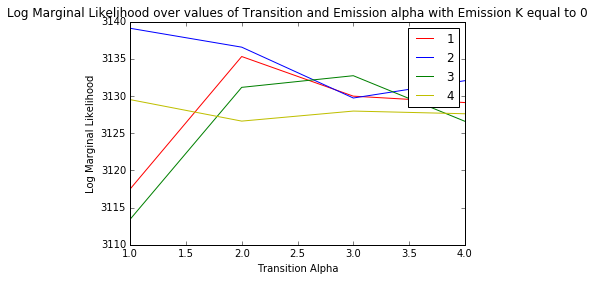

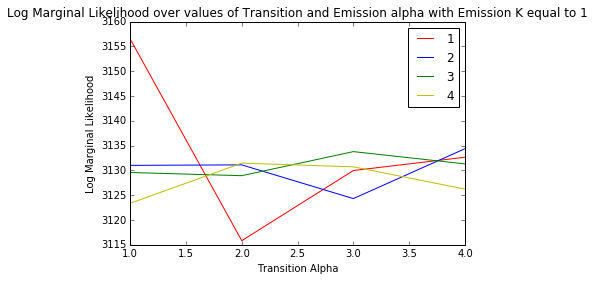

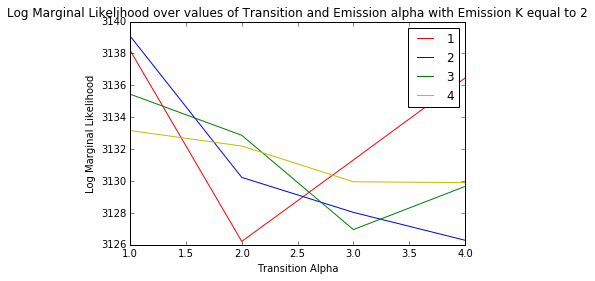

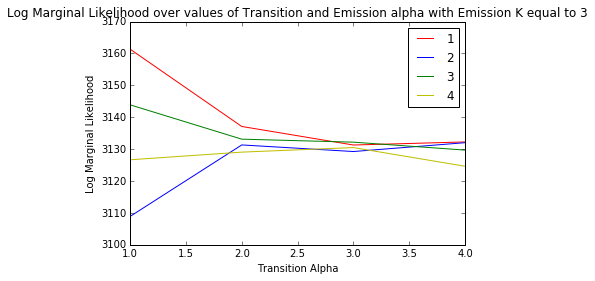

In [9]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.title("Log Marginal Likelihood over values of Transition and Emission alpha with Emission K equal to " + str(i))
    plt.plot(range(1, 5), marginalL[:, 0, i], "r", range(1, 5), marginalL[:, 1, i], "b",
         range(1, 5), marginalL[:, 2, i], "g", range(1, 5), marginalL[:, 3, i], "y")
    plt.legend(range(1, 5))
    plt.ylabel("Log Marginal Likelihood")
    plt.xlabel("Transition Alpha")
    plt.show()

In [20]:
# write the Log Marginal Likelihoods to file so I don't have to do this again
for k in range(4):
    numpy.savetxt("3e_likelihood_eK" + str(k+1) + ".csv", marginalL[:, :, k], fmt = "%.5f", delimiter = ",")

It looks like the optimal parameters are alpha of 1 for transition, an alpha of 2 for emission, and a K of 3. I can now use those to find the emission and transition probabilities for the test set.

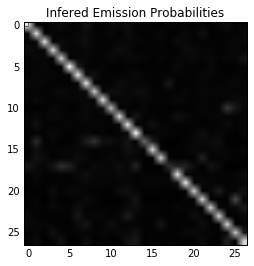

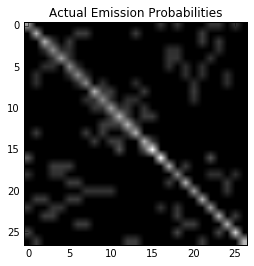

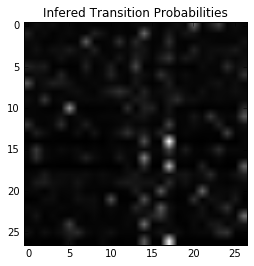

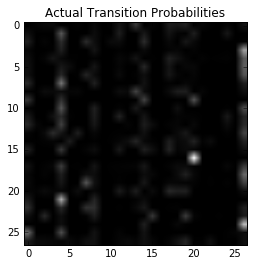

In [8]:
import matplotlib.pyplot as plt

seq, esttransition, estemission = HMMGibbs(testvis, 5000, 1, 2, 3)

# plot the emission and transition probabilities to compare to the actual values.
plt.imshow(numpy.mean(estemission[2000:, :, :], axis = 0), cmap = "gray")
plt.title("Infered Emission Probabilities")
plt.show()
plt.imshow(emission, cmap = "gray")
plt.title("Actual Emission Probabilities")
plt.show()
plt.imshow(numpy.mean(esttransition[2000:, :, :], axis = 0), cmap = "gray")
plt.title("Infered Transition Probabilities")
plt.show()
plt.imshow(transition, cmap = "gray")
plt.title("Actual Transition Probabilities")
plt.show()

The images are rather blurry due to all the comparisons, but major trends are visible. There are some significant differences between the infered and actual transition and emission probabilities. Most clear among them is the fact that the infered probabilities tend to be lower than the actual ones. However, they exhibit a similar structure, with the diagonal of 1s in the emission probabilities and the bright vertical stripes in the transition probabilities. The stripes are in different places, but that may reflect the somewhat small sentences I used.